The goal of this notebook is to pridict the aparent color of a silicon film. This work mostly follows from the work presented in the paper "Silicon colors: spectral selective perfect light absorption in single layer silicon films on aluminum surface and its thermal tunability" by Seyed Sadreddin Mirshafieyan and Junpeng Guo (https://opg.optica.org/oe/fulltext.cfm?uri=oe-22-25-31545&id=306286).

The current plan is to first use the equations that they provide to calutate the spectral response of a silicon film, then convert this to a real color space using color matching functions. If I acheive these goals I will decide what is the best way to move on.

Some assumptions that I will make for now the illumination is TE polarized white light at 45 degrees and the silicon amorphous.

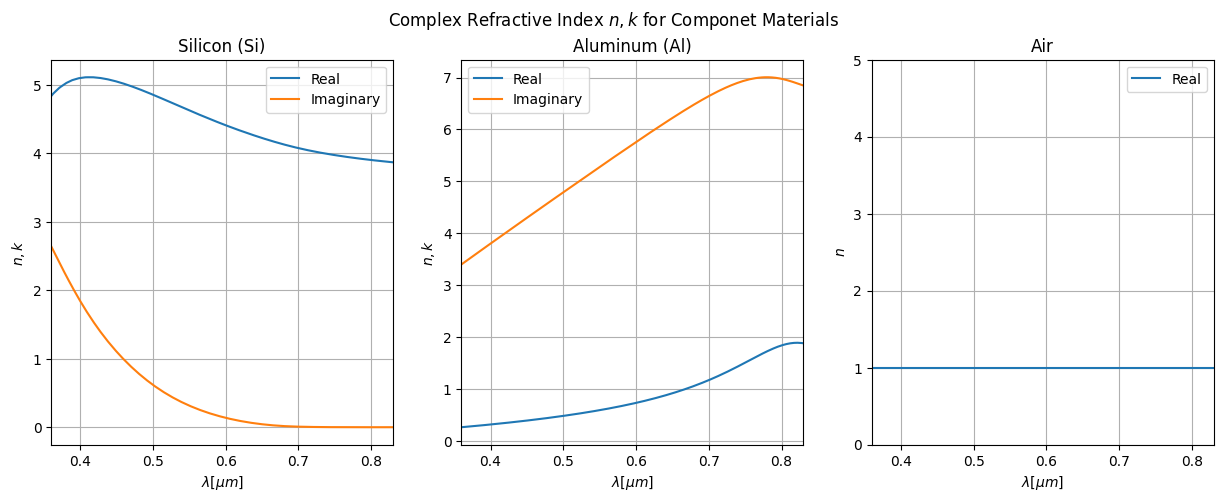

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import pandas as pd

λ_min, λ_max = 0.36, 0.83 #μm
λ = np.arange(λ_min, λ_max+0.001, 0.001)  # μm

n_air = pd.read_csv(
    r"https://refractiveindex.info/data_csv.php?datafile=database/data/other/mixed%20gases/air/nk/Ciddor.yml"
)
n_Si = pd.read_csv(
    r"https://refractiveindex.info/data_csv.php?datafile=database/data/main/Si/nk/Franta.yml"
)
n_Al = pd.read_csv(
    r"https://refractiveindex.info/data_csv.php?datafile=database/data/main/Al/nk/Cheng.yml"
)


n_air = (n_air.apply(pd.to_numeric, errors="coerce")).to_numpy()

n_Si = np.transpose(
    np.array(
        [
            n_Si.apply(pd.to_numeric, errors="coerce").to_numpy()[0:230, 0],
            (
                (n_Si.apply(pd.to_numeric, errors="coerce")).to_numpy()[0:230, 1]
                + (n_Si.apply(pd.to_numeric, errors="coerce")).to_numpy()[-230:, 1] * 1j
            ),
        ]
    )
)

n_Al = np.transpose(
    np.array(
        [
            n_Al.apply(pd.to_numeric, errors="coerce").to_numpy()[0:427, 0],
            (
                (n_Al.apply(pd.to_numeric, errors="coerce")).to_numpy()[0:427, 1]
                + (n_Al.apply(pd.to_numeric, errors="coerce")).to_numpy()[-427:, 1] * 1j
            ),
        ]
    )
)

n_air = interpolate.interp1d(n_air[:, 0], n_air[:, 1])
n_Si = interpolate.interp1d(n_Si[:, 0], n_Si[:, 1])
n_Al = interpolate.interp1d(n_Al[:, 0], n_Al[:, 1])

# A convenient way to verify the imports is to plot...
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[15, 5])
plt.suptitle("Complex Refractive Index $n,k$ for Componet Materials")
axs[0].set(
    title="Silicon (Si)",
    xlabel=r"$\lambda [\mu m]$",
    ylabel="$n,k$",
    xlim=(λ_min, λ_max),
)
axs[0].plot(λ, np.real(n_Si(λ)), label="Real")
axs[0].plot(λ, np.imag(n_Si(λ)), label="Imaginary")
axs[0].grid()
axs[0].legend()

axs[1].set(
    title="Aluminum (Al)",
    xlabel=r"$\lambda [\mu m]$",
    ylabel="$n,k$",
    xlim=(λ_min, λ_max),
)
axs[1].plot(λ, np.real(n_Al(λ)), label="Real")
axs[1].plot(λ, np.imag(n_Al(λ)), label="Imaginary")
axs[1].grid()
axs[1].legend()

axs[2].set(
    title="Air",
    xlabel=r"$\lambda [\mu m]$",
    ylabel="$n$",
    ylim=(0, 5),
    xlim=(λ_min, λ_max),
)
axs[2].plot(λ, n_air(λ), label="Real")
axs[2].grid()
axs[2].legend()

plt.show()

In [151]:
k_0 = 2 * np.pi / λ
d = 0.110  # μm
θ = 45 * np.pi / 180

Now to start with the calculation of the wavelength dependent response of the film. The goal here is to calculate $R = |r|^2$, where 

<math display="block" id="m1" other="display-block-added-in-postconversion"><mrow><mi>r</mi><mo>=</mo><mfrac><mrow><msub><mi>r</mi><mrow><mn>12</mn></mrow></msub><mo>+</mo><msub><mi>r</mi><mrow><mn>23</mn></mrow></msub><msup><mi>e</mi><mrow><mo>−</mo><mn>2</mn><mi>j</mi><mi>φ</mi></mrow></msup></mrow><mrow><mn>1</mn><mo>+</mo><msub><mi>r</mi><mrow><mn>12</mn></mrow></msub><msub><mi>r</mi><mrow><mn>23</mn></mrow></msub><msup><mi>e</mi><mrow><mo>−</mo><mn>2</mn><mi>j</mi><mi>φ</mi></mrow></msup></mrow></mfrac><mo>.</mo></mrow></math>.

As mentioned above I will be considering the TE polarization for now. This means that $r_12$ and $r_23$ are given by, 

<math display="block" id="m2" other="display-block-added-in-postconversion"><mrow><msub><mi>r</mi><mrow><mn>12</mn></mrow></msub><mo>=</mo><mfrac><mrow><msub><mi>k</mi><mrow><mn>1</mn><mi>y</mi></mrow></msub><mo>−</mo><msub><mi>k</mi><mrow><mn>2</mn><mi>y</mi></mrow></msub></mrow><mrow><msub><mi>k</mi><mrow><mn>1</mn><mi>y</mi></mrow></msub><mo>+</mo><msub><mi>k</mi><mrow><mn>2</mn><mi>y</mi></mrow></msub></mrow></mfrac><mo>,</mo><mi></mi><mi></mi><mi></mi><mi></mi><mi></mi><mi></mi><msub><mi>r</mi><mrow><mn>23</mn></mrow></msub><mo>=</mo><mfrac><mrow><msub><mi>k</mi><mrow><mn>2</mn><mi>y</mi></mrow></msub><mo>−</mo><msub><mi>k</mi><mrow><mn>3</mn><mi>y</mi></mrow></msub></mrow><mrow><msub><mi>k</mi><mrow><mn>2</mn><mi>y</mi></mrow></msub><mo>+</mo><msub><mi>k</mi><mrow><mn>3</mn><mi>y</mi></mrow></msub></mrow></mfrac><mo>.</mo></mrow></math>.

For completness the TM versions are

<math display="block" id="m3" other="display-block-added-in-postconversion"><mrow><msub><mi>r</mi><mrow><mn>12</mn></mrow></msub><mo>=</mo><mfrac><mrow><msub><mi>n</mi><mn>2</mn></msub><msup><mrow></mrow><mn>2</mn></msup><msub><mi>k</mi><mrow><mn>1</mn><mi>y</mi></mrow></msub><mo>−</mo><msub><mi>n</mi><mn>1</mn></msub><msup><mrow></mrow><mn>2</mn></msup><msub><mi>k</mi><mrow><mn>2</mn><mi>y</mi></mrow></msub></mrow><mrow><msub><mi>n</mi><mn>2</mn></msub><msup><mrow></mrow><mn>2</mn></msup><msub><mi>k</mi><mrow><mn>1</mn><mi>y</mi></mrow></msub><mo>+</mo><msub><mi>n</mi><mn>1</mn></msub><msup><mrow></mrow><mn>2</mn></msup><msub><mi>k</mi><mrow><mn>2</mn><mi>y</mi></mrow></msub></mrow></mfrac><mo>,</mo><mi></mi><mi></mi><mi></mi><mi></mi><mi></mi><msub><mi>r</mi><mrow><mn>23</mn></mrow></msub><mo>=</mo><mfrac><mrow><msub><mi>n</mi><mn>3</mn></msub><msup><mrow></mrow><mn>2</mn></msup><msub><mi>k</mi><mrow><mn>2</mn><mi>y</mi></mrow></msub><mo>−</mo><msub><mi>n</mi><mn>2</mn></msub><msup><mrow></mrow><mn>2</mn></msup><msub><mi>k</mi><mrow><mn>3</mn><mi>y</mi></mrow></msub></mrow><mrow><msub><mi>n</mi><mn>3</mn></msub><msup><mrow></mrow><mn>2</mn></msup><msub><mi>k</mi><mrow><mn>2</mn><mi>y</mi></mrow></msub><mo>+</mo><msub><mi>n</mi><mn>2</mn></msub><msup><mrow></mrow><mn>2</mn></msup><msub><mi>k</mi><mrow><mn>3</mn><mi>y</mi></mrow></msub></mrow></mfrac><mo>.</mo></mrow></math>.

Finally two other important equations are given in the text,

<math display="block" id="m4" other="display-block-added-in-postconversion"><mrow><msub><mi>k</mi><mrow><mi>i</mi><mi>y</mi></mrow></msub><mo>=</mo><msub><mi>k</mi><mn>0</mn></msub><msup><mrow><mo stretchy="false">[</mo><mo stretchy="false">(</mo><msub><mi>n</mi><mi>i</mi></msub><msup><mrow></mrow><mn>2</mn></msup><mo>−</mo><msub><mi>n</mi><mn>1</mn></msub><msup><mrow></mrow><mn>2</mn></msup><msup><mrow><mi>sin</mi></mrow><mn>2</mn></msup><mo stretchy="false">(</mo><mi>θ</mi><mo stretchy="false">)</mo><mo stretchy="false">)</mo><mo stretchy="false">]</mo></mrow><mrow><mn>1</mn><mo>/</mo><mn>2</mn></mrow></msup></mrow></math>

<math display="block" id="m5" other="display-block-added-in-postconversion"><mrow><msub><mi>&#x3C6;</mi><mo>=</mo><msub><mi>k</mi><mrow><mn>2</mn><mi>y</mi></mrow></msub><mi>d</mi></math>

So working these backwards...

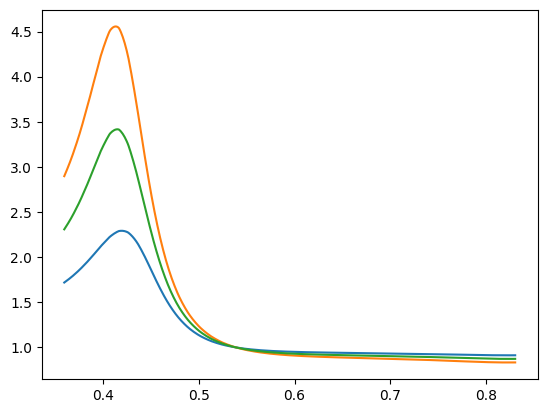

In [165]:
def calculate_reflectance(d: float = 0.030, θ: float = 45):
    """
    Calcuates the reflectance for a given thickness (d) and angle (θ)
    for a silicon thin film over the visible spectrum.

    Parameters
    ----------
    d : float
        Thickness of the film
    θ : float
        The angle of incidence

    Returns
    -------
    tuple
        The TE, TM, and average reflectance
    """
    θ = θ * np.pi / 180
    n_1, n_2, n_3 = n_air(λ), n_Si(λ), n_Al(λ)

    k_1y = k_0 * (n_1**2 - n_1**2 * (np.sin(θ)) ** 2) ** 0.5
    k_2y = k_0 * (n_2**2 - n_1**2 * (np.sin(θ)) ** 2) ** 0.5
    k_3y = k_0 * (n_3**2 - n_1**2 * (np.sin(θ)) ** 2) ** 0.5
    φ = k_2y * d

    r_12TE = (k_1y - k_2y) / (k_1y + k_2y)
    r_23TE = (k_2y - k_3y) / (k_2y + k_3y)

    r_12TM = (n_2**2 * k_1y - n_1**2 * k_2y) / (n_2**2 * k_1y + n_1**2 * k_2y)
    r_23TM = (n_3**2 * k_2y - n_2**2 * k_3y) / (n_3**2 * k_2y + n_2**2 * k_3y)

    r_TE = (r_12TE + r_23TE * np.exp(-2 * 1j * φ)) / (
        1 + r_12TE * r_23TE * np.exp(-2 * 1j * φ)
    )
    R_TE = np.abs(r_TE) ** 2

    r_TM = (r_12TM + r_23TM * np.exp(-2 * 1j * φ)) / (
        1 + r_12TM * r_23TM * np.exp(-2 * 1j * φ)
    )
    R_TM = np.abs(r_TM) ** 2

    R = (R_TE + R_TM) / 2
    return R_TE, R_TM, R

R_TE, R_TM, R = calculate_reflectance()
plt.plot(λ, R_TE)
plt.plot(λ, R_TM)
plt.plot(λ, R)
plt.show()

This result does not match the exerimental results of the paper very well at all. One possibly important factor that I am not considering is that they had to include the reflectance from the glass layer. This means that in reality the aluminium layer is also acting like a film. I don't yet know how to consider this in the calculation. It is also likely that I have made some error. I will move on to trying to calculate the apparent color of the film. 

## Color Science
Color science is an inexact science with many potholes. One consideration to make is the light sorce. Above I have handwavingly considered using a white light source. In the actual experiments we will only be using red (633 nm) blue (540 nm) and green (577 nm?) laser sources. I am not sure yet how I will go about the optimization of the film to have a specific color, or even what the best way to estimate that color is (CIEXYZ, CIELUV, or CIELAB). This blog post does a decent job sumarizing many important aspects of color science. Regardless of which system (or colormatching funtion) I choose the first step should be to calculate the $R$, $G$, $B$ values. For this I will start with the 1931 CIE CMFs which I got from http://www.cvrl.org/

In [154]:
CMF_1931 = pd.read_csv(r"ciexyz31_1.csv", names=['r', 'g', 'b'], index_col=0)

In [166]:
def calculate_RGB(R: np.ndarray):
    """""
    Calculate the RGB values for a given reflectance.

    Parameters
    ----------
    R : ndarray
        Reflectance Specrtum

    Returns
    -------
    tupple
        R, G, B values
    
    """
    r = np.sum(CMF_1931["r"] * R)
    g = np.sum(CMF_1931["g"] * R)
    b = np.sum(CMF_1931["b"] * R)
    r, g, b = (
        r / (r + g + b),
        g / (r + g + b),
        b / (r + g + b),
    )
    return r, g, b

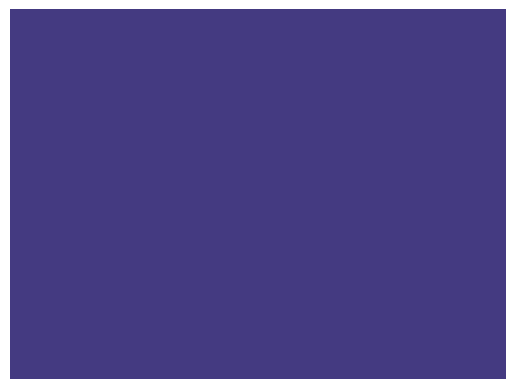

In [169]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define the RGB color
R_TE, R_TM, R = calculate_reflectance()
r, g, b = calculate_RGB(R)

# Create a new figure
fig, ax = plt.subplots()

# Create a square patch with the given color
square = patches.Rectangle(
    (0, 0), 1, 1, linewidth=0, edgecolor="none", facecolor=(r, g, b)
)

# Add the patch to the axes
ax.add_patch(square)

# Set the limits of the axes to the size of the square
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# Remove the axes ticks and frames
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

# Show the plot
plt.show()

In [180]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import FloatSlider, VBox
from IPython.display import display
import ipywidgets as widgets

# Define a function to update the plot based on the slider values
def update_plot(frequency, amplitude):
    R_TE, R_TM, R = calculate_reflectance(amplitude, frequency)

    # Clear the current plot
    plt.clf()

    # Create a new plot
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[15, 5])

    # Set plot labels and title
    axs[0].set(
        title=f"Sine wave: Frequency = {frequency}, Amplitude = {amplitude}",
        xlabel= "x",
        ylabel = "y")
    axs[0].plot(λ, R_TE)
    axs[0].plot(λ, R_TM)
    axs[0].plot(λ, R)

    r, g, b = calculate_RGB(R)
    square = patches.Rectangle(
    (0, 0), 1, 1, linewidth=0, edgecolor="none", facecolor=(r, g, b)
    )

    # Add the patch to the axes
    axs[1].add_patch(square)

    # Set the limits of the axes to the size of the square
    axs[1].set_xlim(0, 1)
    axs[1].set_ylim(0, 1)

    # Remove the axes ticks and frames
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    axs[1].set_frame_on(False)

    # Show the plot
    plt.show()



# Create sliders for frequency and amplitude
angle_slider = FloatSlider(
    min=1, max=179, step=1, value=45, description="Angle"
)
thickness_slider = FloatSlider(
    min=0.01, max=0.2, step=0.001, value=0.03, description="Thickness"
)

# Use interact to create the widget that updates the plot
interact(update_plot, frequency=angle_slider, amplitude=thickness_slider)

interactive(children=(FloatSlider(value=45.0, description='Angle', max=179.0, min=1.0, step=1.0), FloatSlider(…

<function __main__.update_plot(frequency, amplitude)>